Loaded 50 rows
Scenarios: ['A' 'B' 'C' 'D' 'E']
Models: ['lasso' 'NeuralNet' 'nimo_baseline' 'nimo_variant' 'nimoNew']


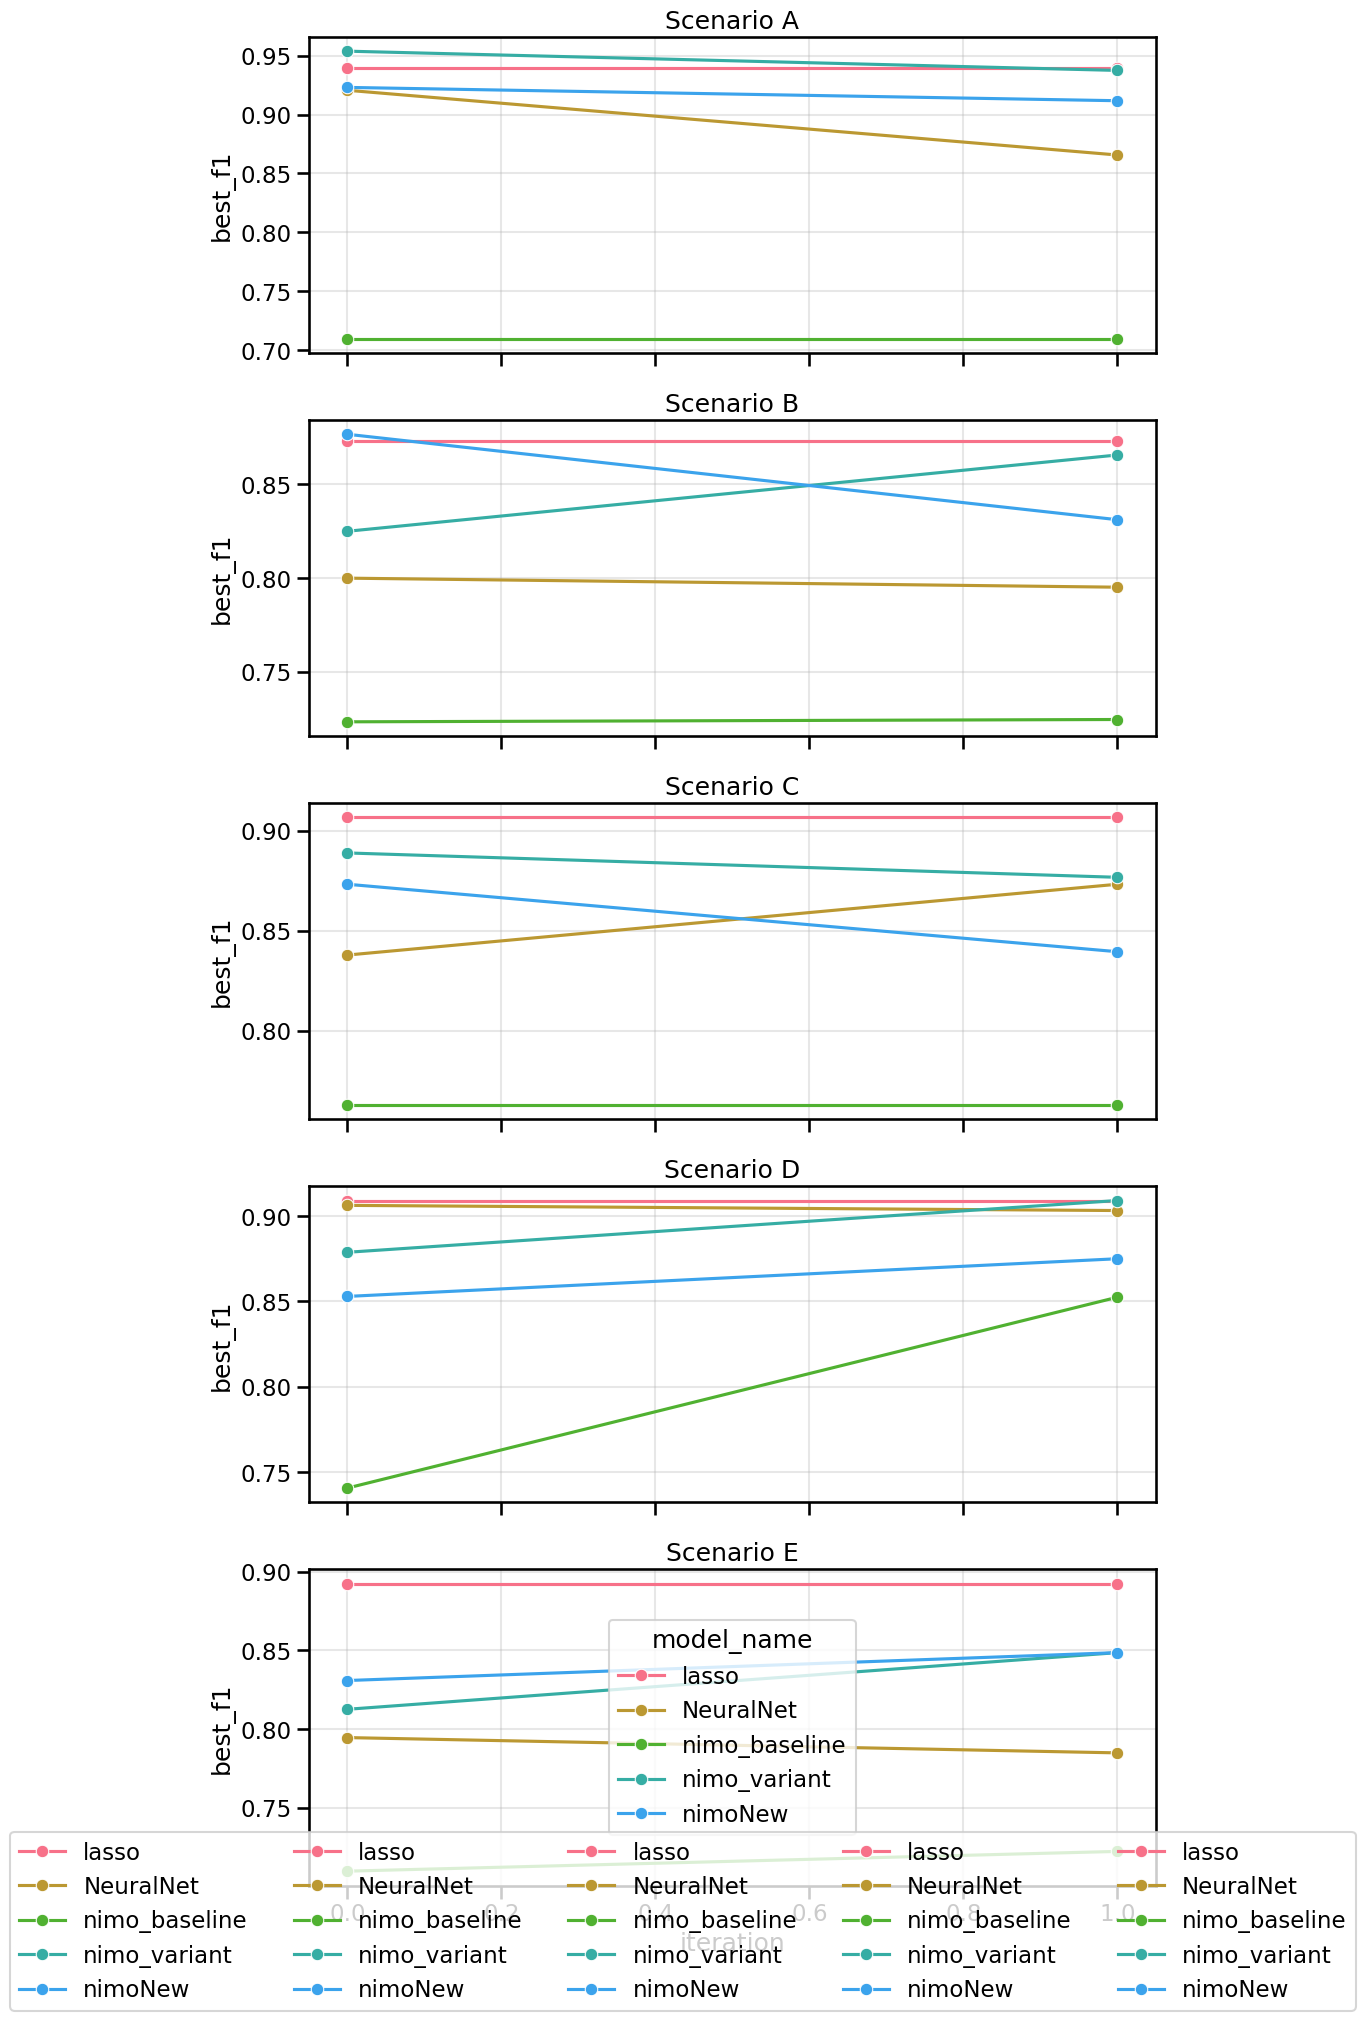

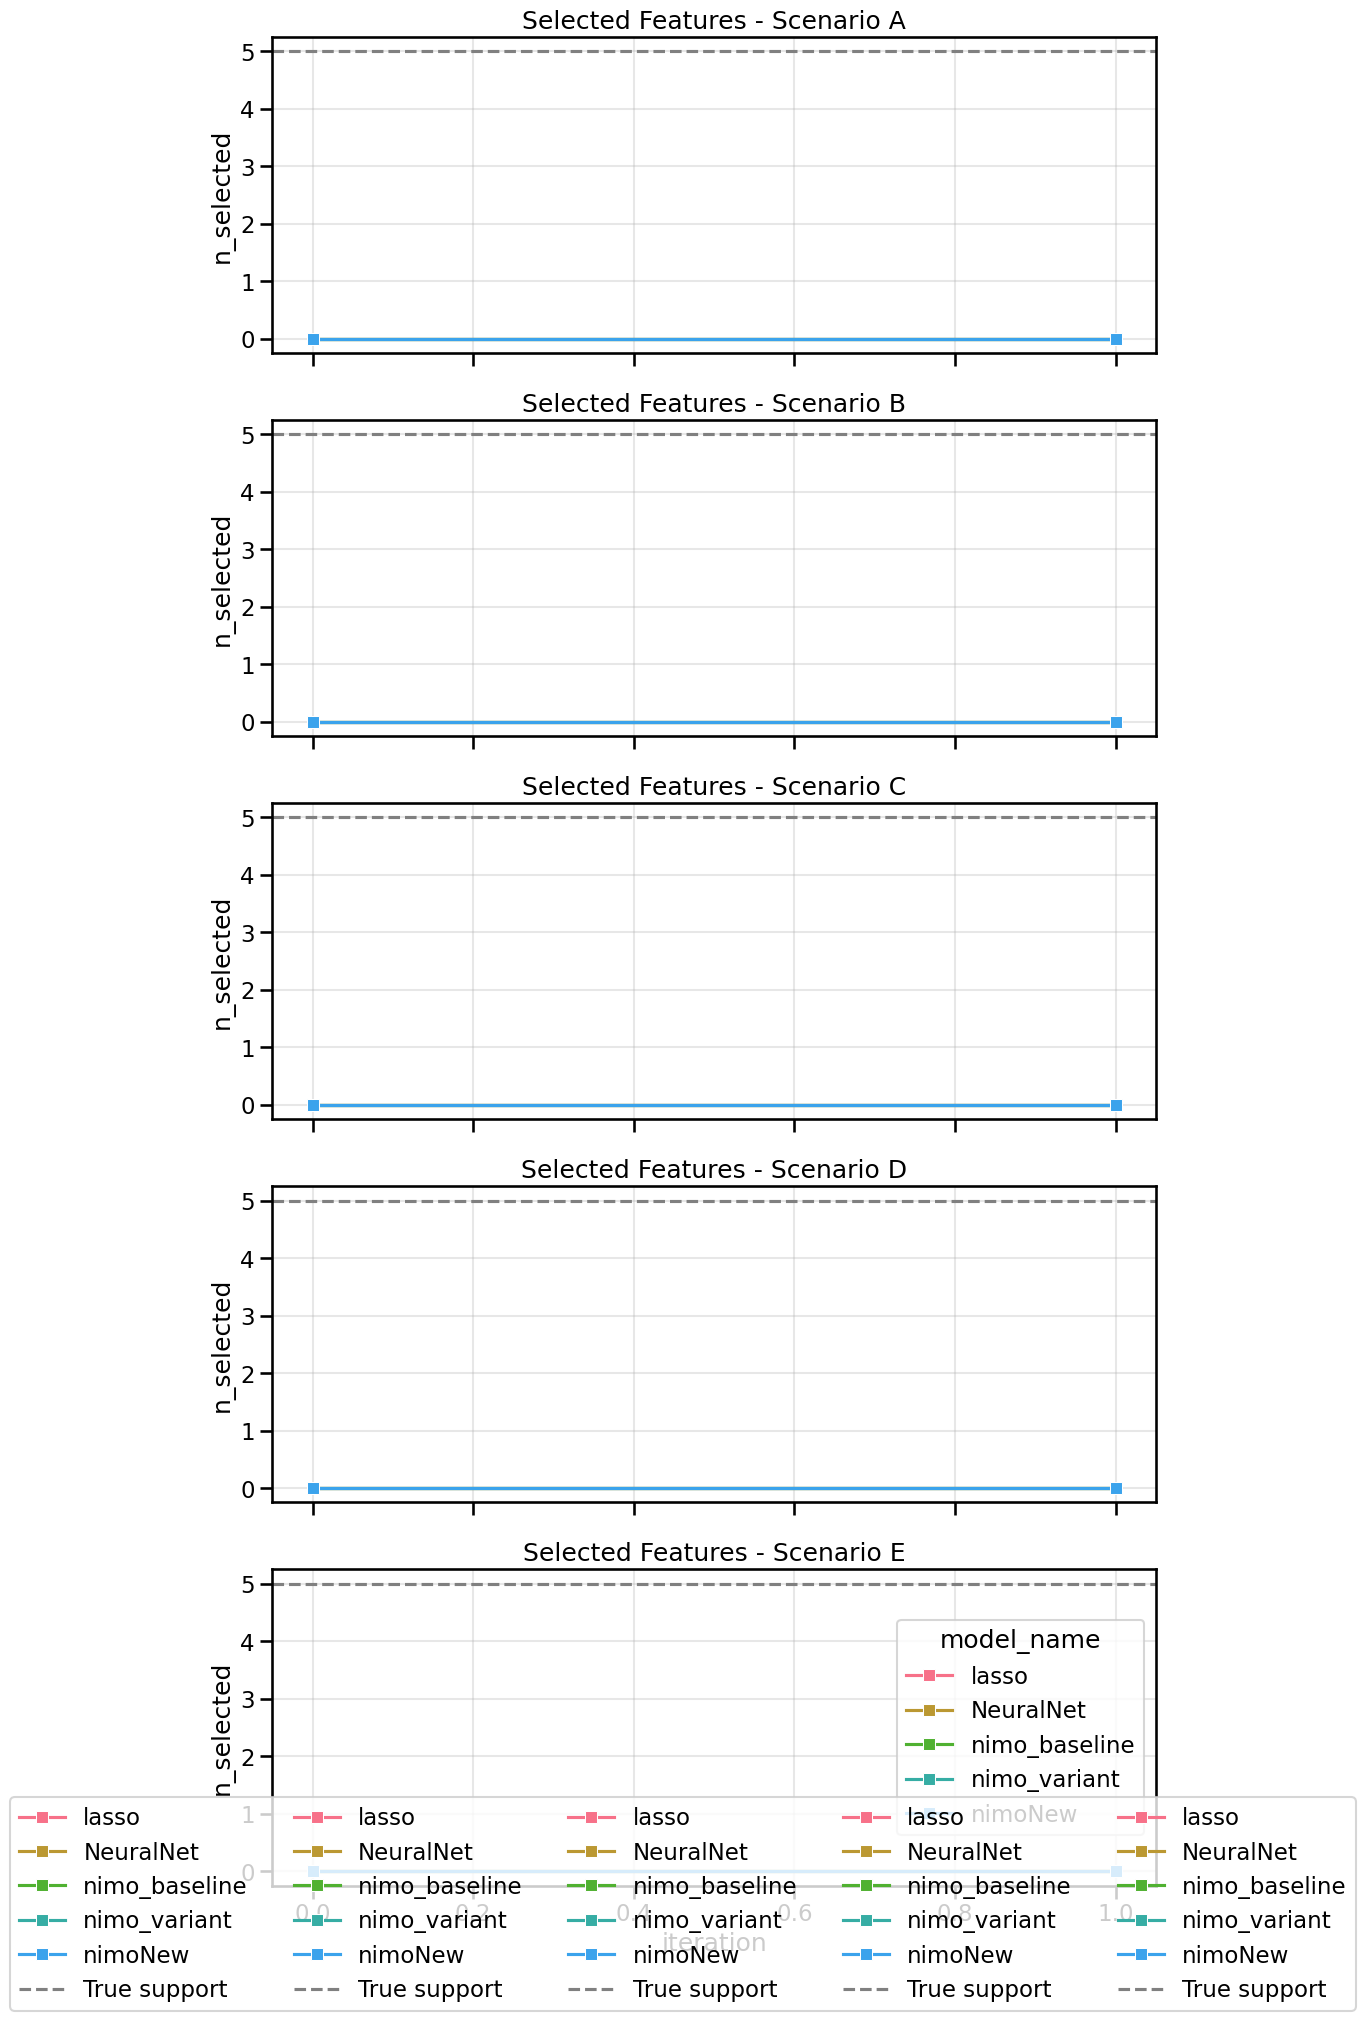

/var/folders/nm/wffg_5x13dv69w58yk8x6vhc0000gn/T/ipykernel_10499/1280581039.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_f1.values, y=avg_f1.index, palette="muted")


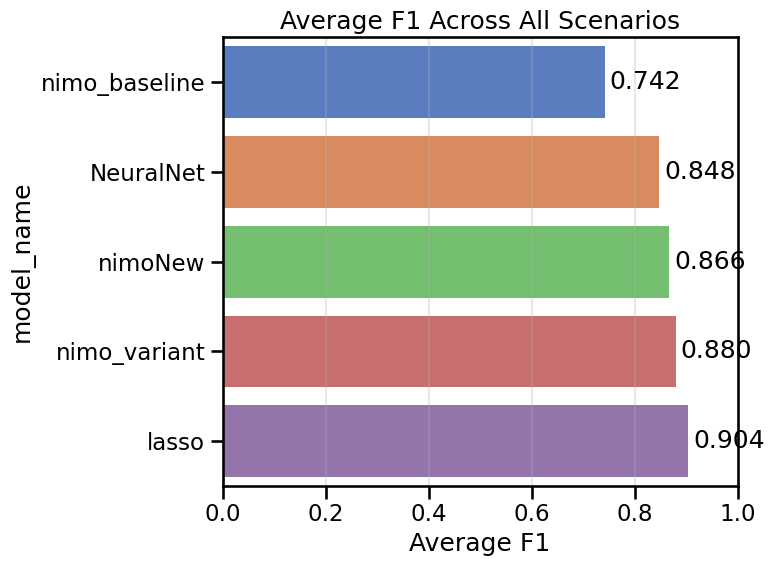

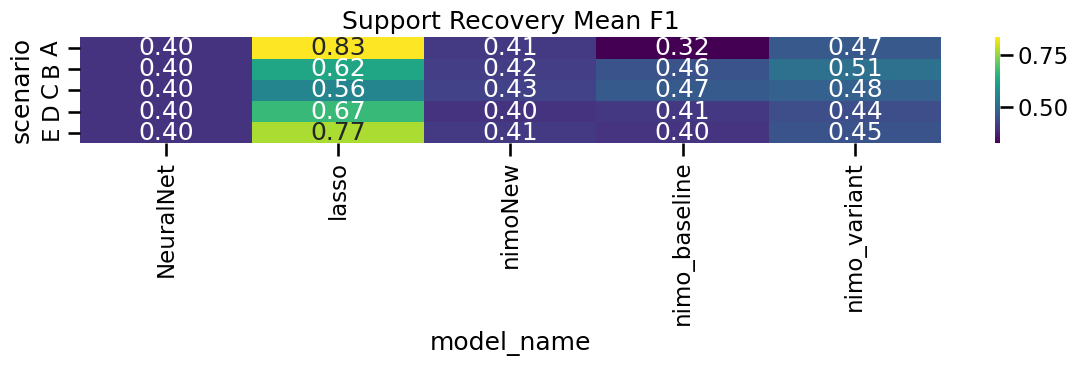

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, json

sns.set_context("talk")

def parse_list_column(x):
    if pd.isna(x) or (isinstance(x,str) and x.strip()==''):
        return []
    if isinstance(x,list):
        return x
    try:
        return json.loads(x)
    except:
        return []

# --- Load & Clean ---
df = pd.read_csv('../results/synthetic/all_model_results_synthetic.csv')
print(f"Loaded {len(df)} rows")

# Drop error runs
if 'error' in df.columns:
    df = df[df['error'].isna()].reset_index(drop=True)

# Parse list‑columns
for col in ['y_pred','y_prob','selected_features','true_support','beta_true']:
    if col in df.columns:
        df[col] = df[col].apply(parse_list_column)

# Numeric conversion
for col in ['best_f1','best_threshold','precision','recall','n_selected','f1_recovery']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure n_selected exists
if 'selected_features' in df.columns:
    df['n_selected'] = df['selected_features'].apply(len)

print("Scenarios:", df['scenario'].unique())
print("Models:", df['model_name'].unique())

# --- 1) Szenario‑Panels F1 ```
fig, axes = plt.subplots(len(df['scenario'].unique()),1, figsize=(10,4*len(df['scenario'].unique())), sharex=True)
for ax, (scen, grp) in zip(axes, df.groupby('scenario')):
    sns.lineplot(data=grp, x='iteration', y='best_f1', hue='model_name', marker='o', ax=ax)
    ax.set_title(f"Scenario {scen}")
    ax.grid(alpha=0.3)
    if ax!=axes[-1]:
        ax.get_legend().remove()
fig.legend(loc='lower center', ncol=len(df['model_name'].unique()), bbox_to_anchor=(0.5, -0.02))
fig.tight_layout()
plt.show()

# --- 2) Feature Count per Szenario ```
fig, axes = plt.subplots(len(df['scenario'].unique()),1, figsize=(10,4*len(df['scenario'].unique())), sharex=True)
for ax, (scen, grp) in zip(axes, df.groupby('scenario')):
    sns.lineplot(data=grp, x='iteration', y='n_selected', hue='model_name', marker='s', ax=ax)
    true_n = grp['n_true_features'].iloc[0] if 'n_true_features' in grp.columns else None
    if true_n is not None:
        ax.axhline(true_n, ls='--', color='gray', label='True support')
    ax.set_title(f"Selected Features - Scenario {scen}")
    ax.grid(alpha=0.3)
    if ax!=axes[-1]:
        ax.get_legend().remove()
fig.legend(loc='lower center', ncol=len(df['model_name'].unique()), bbox_to_anchor=(0.5, -0.02))
fig.tight_layout()
plt.show()

# --- 3) Average F1 Barplot ```
avg_f1 = df.groupby('model_name')['best_f1'].mean().sort_values()
plt.figure(figsize=(8,6))
sns.barplot(x=avg_f1.values, y=avg_f1.index, palette="muted")
for i,(val,lab) in enumerate(zip(avg_f1.values, avg_f1.index)):
    plt.text(val+0.01, i, f"{val:.3f}", va='center')
plt.title("Average F1 Across All Scenarios")
plt.xlabel("Average F1")
plt.xlim(0,1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 4) Support Recovery Heatmap ```
heat_df = df.pivot_table(index='scenario', columns='model_name', values='f1_recovery', aggfunc='mean')
plt.figure(figsize=(12,4))
sns.heatmap(heat_df, annot=True, fmt=".2f", cmap="viridis")
plt.title("Support Recovery Mean F1")
plt.tight_layout()
plt.show()
